<a href="https://colab.research.google.com/github/bozorgpanah/The-Explainable-Machine-Learning-Model-withPrivacy/blob/main/Paper1/MDAV%2BSHAP_BrestCancer_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
"""
MDAV
SHAP
ON
Brest Cancer dataset
"""

'\nMDAV\nSHAP\nON\nBrest Cancer dataset\n'

In [ ]:
#Uploading a dataset from local drive to colab
from google.colab import files
uploaded = files.upload()

Saving brest_cancer.csv to brest_cancer.csv


In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt # data visualization
import seaborn as sns # statistical data visualization
import io

##Reading dataset
df = pd.read_csv(io.BytesIO(uploaded['brest_cancer.csv'])) #Dataset's name == housing.csv
# Dataset is now stored in a Pandas Dataframe
df.info()


# now check for missing values in total bedrooms
df.isnull().sum()
# ------------------------------------------------------------------


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 116 entries, 0 to 115
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             116 non-null    int64  
 1   BMI             116 non-null    float64
 2   Glucose         116 non-null    int64  
 3   Insulin         116 non-null    float64
 4   HOMA            116 non-null    float64
 5   Leptin          116 non-null    float64
 6   Adiponectin     116 non-null    float64
 7   Resistin        116 non-null    float64
 8   MCP.1           116 non-null    float64
 9   Classification  116 non-null    int64  
dtypes: float64(7), int64(3)
memory usage: 9.2 KB


Age               0
BMI               0
Glucose           0
Insulin           0
HOMA              0
Leptin            0
Adiponectin       0
Resistin          0
MCP.1             0
Classification    0
dtype: int64

In [ ]:
##Feature Vector and Target Variable
X = df[['Age', 'BMI', 'Glucose', 'Insulin', 'HOMA', 'Leptin', 'Adiponectin', 'Resistin', 'MCP.1','Classification']] #Feature Vector
y = df['Classification'] #Target Variable

##Splitting the data into train and test data
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0)

print(X_train,y_train)
print("####################################################################################################")
print(X_test,y_test)

     Age        BMI  Glucose  ...  Resistin    MCP.1  Classification
54    49  20.956608       94  ...  23.11770  573.630               2
115   86  27.180000      138  ...   4.35000   90.090               2
95    49  29.777778       70  ...  20.76801  602.486               2
101   66  26.562500       89  ...  14.91922  269.487               2
96    44  27.887617       99  ...  23.03306  407.206               2
..   ...        ...      ...  ...       ...      ...             ...
112   62  26.840000      100  ...   7.32000  330.160               2
67    64  22.222222       98  ...  13.91245  395.976               2
64    59  22.832879       98  ...   8.20490  355.310               2
47    78  25.300000       60  ...   4.66380  209.749               1
44    71  30.300000      102  ...   4.29890  200.976               1

[81 rows x 10 columns] 54     2
115    2
95     2
101    2
96     2
      ..
112    2
67     2
64     2
47     1
44     1
Name: Classification, Length: 81, dtype: int64
##

In [ ]:
#MDAV a microagregation method 
def dist(x,y):
    return np.linalg.norm(x-y)
    
#Stack arrays in sequence vertically (row wise)
def poprow(arr,i):
    pop = arr[i]
    new_array = np.vstack((arr[:i],arr[i+1:]))
    return new_array,pop

def cluster(X, p, k, dist_to_xr):
    c = [p]
    
    if dist_to_xr == None:
        distances = [dist(v[:-1],p[:-1]) for v in X]
    else:
        distances = dist_to_xr
        
    X = X[np.argpartition(distances, k-1)]
    c.extend(X[:k-1])
    X = X[k-1:]
    
    xc = np.array([p[:-1] for p in c], copy=False, ndmin=2)
    yc = np.array([p[-1] for p in c], copy=False)
    cl = (xc, yc)
    
    return X, cl

def mdav(X, y, k):
    D = np.column_stack((X,y)) #D is a matrix of variables
    clusters = []
    centroids = []
    while len(D) >= 3*k:
        # Centroid
        xm = np.mean(D, axis=0) #xm is an array includes mean in each variables (each columns)
        # Furthest from centroid
        xri = np.argmax([dist(v[:-1],xm[:-1]) for v in D])#Find furthest from the centroid in each vector and it's called xri
        D, xr = poprow(D, xri)
        # Furthest from furthest from centroid
        dist_to_xr = [dist(v[:-1],xr[:-1]) for v in D]
        xsi = np.argmax(dist_to_xr)
        dist_to_xr = dist_to_xr[:xsi]+dist_to_xr[xsi+1:]
        D, xs = poprow(D, xsi) 

        #cluster of xr
        D, c = cluster(D, xr, k, dist_to_xr)
        clusters.append(c)
        #cluster of xs
        D, c = cluster(D, xs, k, None)
        clusters.append(c)
        
    if len(D) >= 2*k and len(D) < 3*k:
        # Centroid
        xm = np.mean(D, axis=0)
        # Furthest from centroid
        xri = np.argmax([dist(v[:-1],xm[:-1]) for v in D])
        D, xr = poprow(D, xri)
        #cluster of xr
        D, c = cluster(D, xr, k, None)
        clusters.append(c)
        
        # rest of points
        xc = np.array([p[:-1] for p in D[:]], copy=False, ndmin=2)
        yc = np.array([p[-1] for p in D[:]], copy=False)
        cl = (xc, yc)
        clusters.append(cl)     
    else:
        # rest of points
        xc = np.array([p[:-1] for p in D[:]], copy=False, ndmin=2)
        yc = np.array([p[-1] for p in D[:]], copy=False)
        cl = (xc, yc)
        clusters.append(cl)
    
    centroids = np.array([np.mean(c[0],axis=0) for c in clusters], copy=False)
    
    return clusters, centroids

In [ ]:
for i in range(16):
  i = i+1
  print(int(116/i))
 

116
58
38
29
23
19
16
14
12
11
10
9
8
8
7
7


In [ ]:
#We use smaller K amount
import csv
import time
import statistics 
exec_times = []

##for kk in range(15):
##  print(kk+1)  k = int(116/(kk+1))
i = 0  #116, 58,38,29,23,19,16,14,12,11,10,9,8,8,7,7
k = int(116/8.9)
clusterings = []
centroids = []
maskedData = []
print(f'k = {k}')

#for k in K:
start = time.time()
   #print(k, K)
clustering, centroid = mdav(X, y, k) #clustering, centroid = mdav(X_train, y_train, k)
clusterings.append(clustering)
centroids.append(centroid)


with open('clusterings_csv.csv','w',newline='') as fp:
  c = csv.writer(fp, delimiter = ',')    
  for line in clusterings:
      c.writerows(line)
################################################################################
j=0
with open('centroids_BrestCancer.csv','w',newline='') as f:
    fieldnames = ['Age', 'BMI', 'Glucose', 'Insulin', 'HOMA', 'Leptin', 'Adiponectin', 'Resistin', 'MCP.1','Classification']
    z = csv.DictWriter(f, fieldnames=fieldnames)
    z.writeheader()
    z = csv.writer(f, delimiter = ',')
    for line in centroids:
       for j in range(0,k):
          z.writerows(line)

i = 0
while i<k:
 maskedData.append(centroid) 
 i += 1  

end = time.time()
exec_times.append(end-start)
    #arr_ctr_num.append(len(centroids))
print(f'Time for calculating = {exec_times}')

 #Saveing centroids in a file
f_centroids = open("Centroids.txt","wt")
f_centroids.write("\n"+str(centroids)+"\n")
f_clusters = open("Clusers.txt","wt")
f_clusters.write("\n"+str(clusterings)+"\n")
f_maskedData = open("MaskedData.txt","wt")
f_maskedData.write("\n"+str(maskedData)+"\n")
f_maskedData.close()
f_centroids.close()
f_clusters.close()
files.download("centroids_BrestCancer.csv")

k = 13
Time for calculating = [0.037419795989990234]


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
#SHAP
!pip install shap #Install SHAP library
#Uploading a dataset from local drive to colab
#from google.colab import files
#uploaded = files.upload()

     |████████████████████████████████| 356 kB 13.5 MB/s 
  Created wheel for shap: filename=shap-0.39.0-cp37-cp37m-linux_x86_64.whl size=491670 sha256=23fb84bd50e91ecb12428d9de48ec99fe3371017acb21bb617fcee91f1b38b6a
  Stored in directory: /root/.cache/pip/wheels/ca/25/8f/6ae5df62c32651cd719e972e738a8aaa4a87414c4d2b14c9c0
Successfully built shap


In [ ]:
#Uploading a dataset from local drive to colab
from google.colab import files
uploaded = files.upload()

Saving brest_cancer.csv to brest_cancer.csv


In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt # data visualization
import seaborn as sns # statistical data visualization
import io

##Reading dataset
df = pd.read_csv(io.BytesIO(uploaded['brest_cancer.csv'])) #''centroids_BrestCancer (k=13).csv'])) #Dataset's name == USA_Housing.csv OR == centroids_csv (ProtectedDataset)k=3.csv 
# Dataset is now stored in a Pandas Dataframe
df.info()

# now check for missing values in total bedrooms
df.isnull().sum()
# ------------------------------------------------------------------

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 116 entries, 0 to 115
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             116 non-null    int64  
 1   BMI             116 non-null    float64
 2   Glucose         116 non-null    int64  
 3   Insulin         116 non-null    float64
 4   HOMA            116 non-null    float64
 5   Leptin          116 non-null    float64
 6   Adiponectin     116 non-null    float64
 7   Resistin        116 non-null    float64
 8   MCP.1           116 non-null    float64
 9   Classification  116 non-null    int64  
dtypes: float64(7), int64(3)
memory usage: 9.2 KB


Age               0
BMI               0
Glucose           0
Insulin           0
HOMA              0
Leptin            0
Adiponectin       0
Resistin          0
MCP.1             0
Classification    0
dtype: int64

In [ ]:
import math
##Feature Vector and Target Variable
X = df[['Age', 'BMI', 'Glucose', 'Insulin', 'HOMA', 'Leptin', 'Adiponectin', 'Resistin', 'MCP.1']] #Feature Vector
y = df['Classification'] #Target Variable

##Splitting the data into train and test data
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0)

"""
print(X_train,y_train)
print("####################################################################################################")
print(X_test,y_test)
"""
##Building the model with --> Random Forest Classifier
from sklearn.ensemble import RandomForestRegressor
model = RandomForestRegressor(max_depth=6, random_state=0, n_estimators=10)
model.fit(X_train, y_train)

##Generating Predictions
y_pred = model.predict(X_test)
print("Prediction: ", y_pred)

##Evaluating Performance
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(y_test, y_pred)**(0.5)
print("mean_squared_error: ", mse)

rmse = math.sqrt(mse)
print('\n\nAccuracy for Random Forest:',100*max(0,rmse)) 


Prediction:  [1.2 1.2 1.  1.1 1.7 1.9 1.7 2.  1.4 1.8 1.8 1.3 1.9 1.2 1.7 2.  1.3 1.8
 1.7 1.8 1.4 1.1 1.7 1.8 2.  2.  2.  1.6 1.6 2.  1.6 1.2 1.5 1.5 1.3]
mean_squared_error:  0.428285618984074


Accuracy for Random Forest: 65.44353436238556


In [ ]:
##SHAP Explanation
#Force Plots
# import shap library
import shap 
from IPython.display import display

# explain the model's predictions using SHAP
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_train)

# visualize the first prediction's explanation 
shap.initjs()
display(shap.force_plot(explainer.expected_value, shap_values[0,:], X_train.iloc[0,:]))


In [ ]:
shap.initjs()
# visualize the training set predictions
#shap.force_plot(explainer.expected_value, shap_values, X_train)


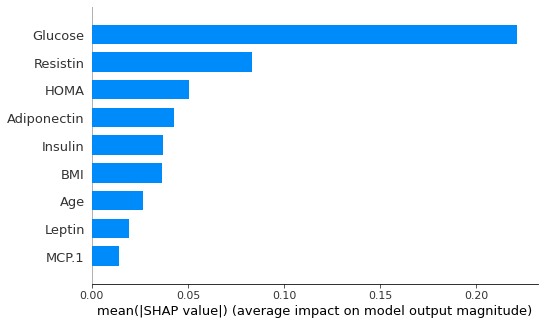

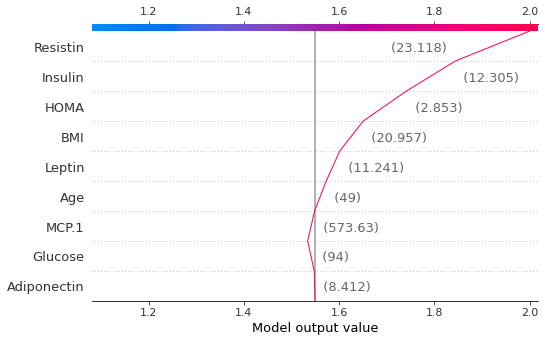

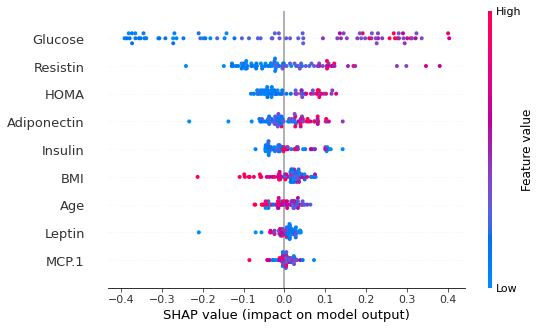

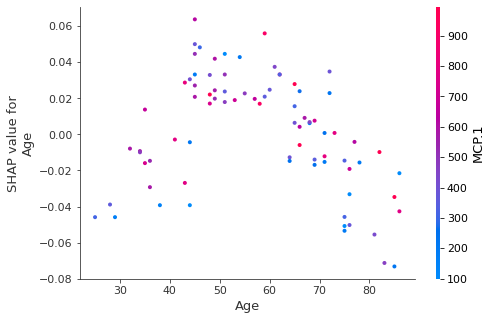

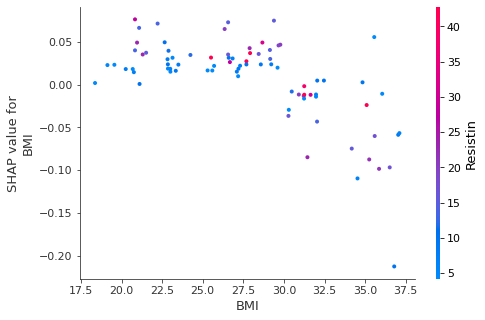

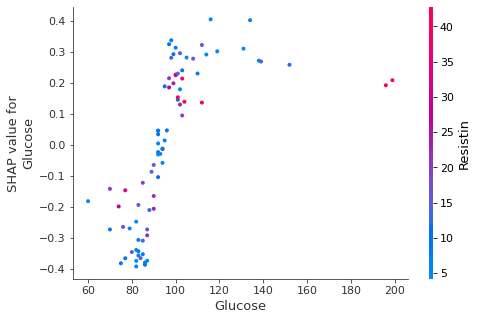

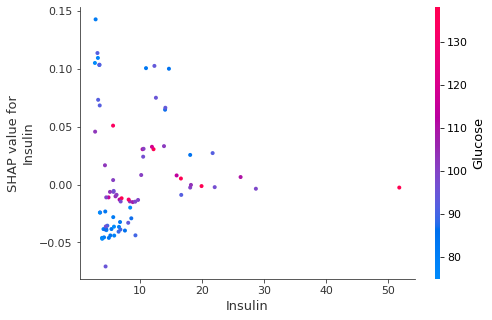

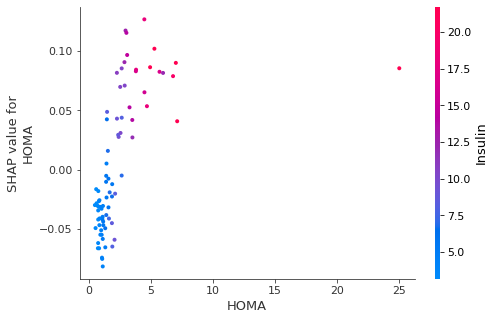

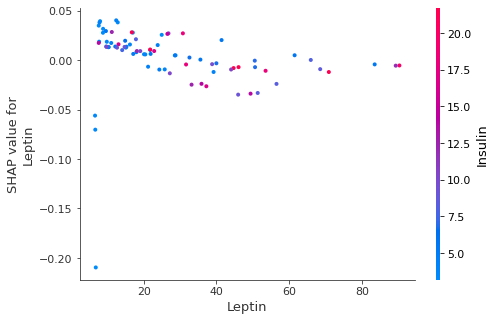

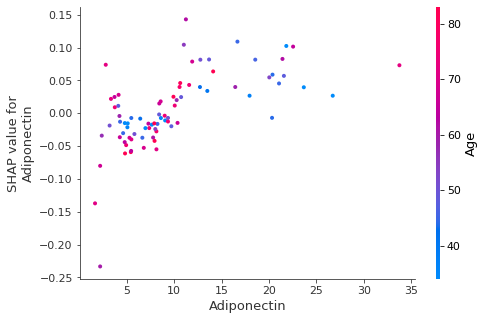

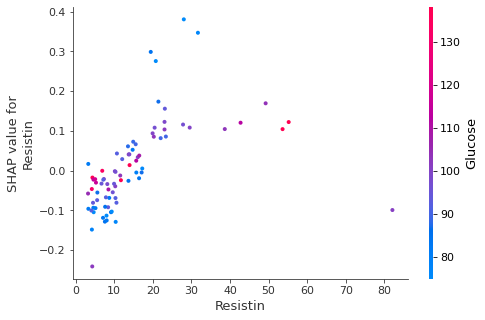

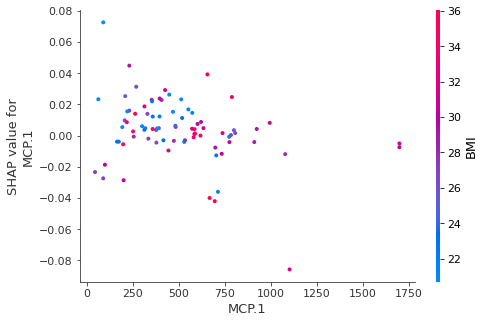

In [ ]:
##SHAP Feature Importance
shap_values = shap.TreeExplainer(model).shap_values(X_train)

shap.approximate_interactions(2,shap_values, X_train)
shap.summary_plot(shap_values, X_train, plot_type="bar")

shap.decision_plot(explainer.expected_value, shap_values[0,:], X_train.iloc[0,:])
##SHAP Summary Plot
shap.summary_plot(shap_values, X_train)

##SHAP Dependence Plot

shap.dependence_plot('Age', shap_values, X_train)
shap.dependence_plot('BMI', shap_values, X_train)
shap.dependence_plot('Glucose', shap_values, X_train)
shap.dependence_plot('Insulin', shap_values, X_train)
shap.dependence_plot('HOMA', shap_values, X_train)
shap.dependence_plot('Leptin', shap_values, X_train)
shap.dependence_plot('Adiponectin', shap_values, X_train)
shap.dependence_plot('Resistin', shap_values, X_train)
shap.dependence_plot('MCP.1', shap_values, X_train)
